# London Rental Market Analysis
Focus: what drives rental prices (size, bedrooms, furnishing, property type, transport access).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

df = pd.read_csv("../data/raw/rent_ads_rightmove_extended.csv", low_memory=False)

df = df.rename(columns={
    "Let type": "let_type",
    "Furnish Type": "furnish_type",
    "Coucil Tax": "council_tax",
    "PROPERTY TYPE": "property_type",
    "BEDROOMS": "bedrooms",
    "BATHROOMS": "bathrooms"
})

df["size_sqft"] = (
    df["SIZE"].astype(str)
    .str.replace(",", "", regex=False)
    .str.extract(r"(\d+(?:\.\d+)?)")[0]
    .astype(float)
)

df["avg_distance_to_nearest_station"] = pd.to_numeric(
    df["avg_distance_to_nearest_station"], errors="coerce"
)

df.shape


(3478, 14)

## 1. Property characteristics vs rent


In [ ]:
excluded_types = [
    "Parking",
    "Garages",
    "Mobile Home",
    "House Share",
    "Flat Share",
    "House of Multiple Occupation",
    "Land",
]

apartment_types = [
    "Apartment",
    "Block of Apartments",
    "Flat",
    "Ground Flat",
    "Studio",
    "Penthouse",
    "Duplex",
]

house_types = [
    "House",
    "Terraced",
    "End of Terrace",
    "Semi-Detached",
    "Detached",
    "Town House",
    "Bungalow",
    "Detached Bungalow",
    "Cottage",
    "Chalet",
    "Mews",
    "Maisonette",
    "Ground Maisonette",
]

rent_df = df[df["rent"] > 0].copy()
q1, q3 = rent_df["rent"].quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr
outlier_share = (rent_df["rent"] > upper).mean()

analysis_df = df[(df["rent"] > 0) & (df["rent"] <= upper)].copy()
analysis_df = analysis_df[~analysis_df["property_type"].isin(excluded_types)]

analysis_df["property_category"] = np.select(
    [
        analysis_df["property_type"].isin(apartment_types),
        analysis_df["property_type"].isin(house_types),
    ],
    ["Apartment", "Houses"],
    default="Other"
)

analysis_df = analysis_df[analysis_df["property_category"].isin(["Apartment", "Houses"])]
analysis_df["property_category"].value_counts(dropna=False)


property_category
Apartment    2495
Houses        300
Name: count, dtype: int64

The excluded property types are not typical residential rentals (parking, garages, land) or represent shared/atypical tenures (house/flat shares, HMOs, mobile homes). Keeping them would pull rent means down and make comparisons across bedrooms, size, and furnishing less meaningful.


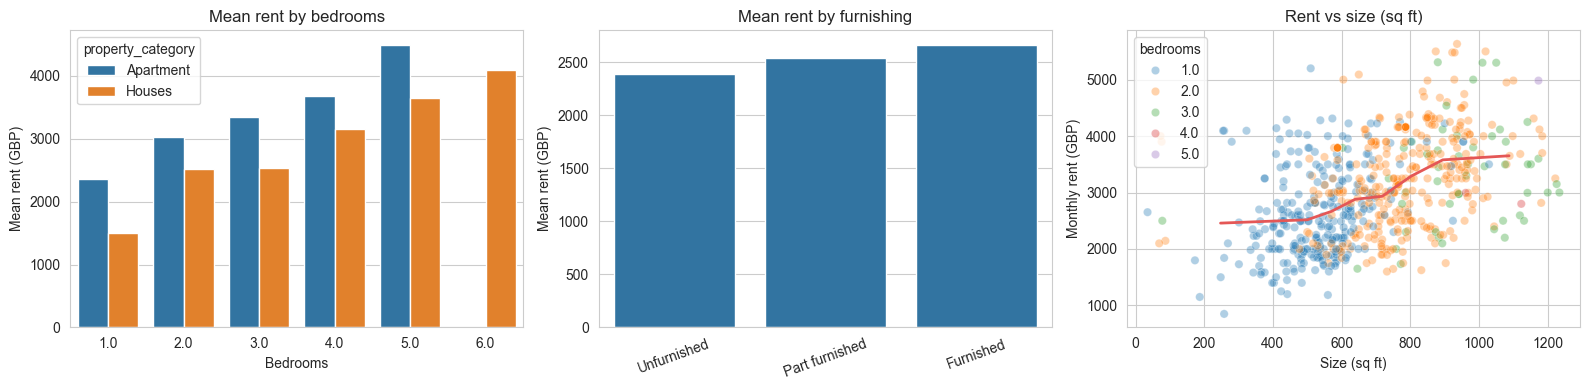

In [ ]:
bed_df = analysis_df[analysis_df["bedrooms"].notna()].copy()
bed_df = bed_df[bed_df["bedrooms"] != 7]
bed_mean = bed_df.groupby(["bedrooms", "property_category"])["rent"].mean().unstack()
bed_counts = bed_df.groupby(["bedrooms", "property_category"])["rent"].size().unstack()

furn_df = analysis_df[analysis_df["furnish_type"].isin(["Unfurnished", "Furnished", "Part furnished"])].copy()
furn_mean = furn_df.groupby("furnish_type")["rent"].mean()

size_df = analysis_df[["size_sqft", "rent", "property_category", "bedrooms"]].dropna().copy()
size_df = size_df[(size_df["size_sqft"] > 0) & (size_df["size_sqft"] <= 1250)]
size_missing_share = analysis_df["size_sqft"].isna().mean()
size_corr = size_df["rent"].corr(size_df["size_sqft"])

bed_mean, bed_counts, furn_mean, size_missing_share, size_corr

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

bed_order = sorted(bed_df["bedrooms"].unique())
sns.barplot(
    x="bedrooms", y="rent", hue="property_category",
    data=bed_df, order=bed_order, estimator=np.mean,
    errorbar=None, ax=axes[0]
)
axes[0].set_title("Mean rent by bedrooms")
axes[0].set_xlabel("Bedrooms")
axes[0].set_ylabel("Mean rent (GBP)")

furn_order = ["Unfurnished", "Part furnished", "Furnished"]
sns.barplot(
    x="furnish_type", y="rent", data=furn_df,
    order=furn_order, estimator=np.mean,
    errorbar=None, ax=axes[1]
)
axes[1].set_title("Mean rent by furnishing")
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean rent (GBP)")
axes[1].tick_params(axis="x", rotation=20)

sns.scatterplot(
    x="size_sqft", y="rent", hue="bedrooms",
    data=size_df, alpha=0.35, ax=axes[2], palette="tab10"
)

size_bins = pd.qcut(size_df["size_sqft"], q=8, duplicates="drop")
size_mean = size_df.groupby(size_bins, observed=False)["rent"].mean().reset_index()
size_mean["bin_mid"] = size_mean["size_sqft"].apply(lambda x: x.mid)
axes[2].plot(size_mean["bin_mid"], size_mean["rent"], color="#E45756", linewidth=2)

axes[2].set_title("Rent vs size (sq ft)")
axes[2].set_xlabel("Size (sq ft)")
axes[2].set_ylabel("Monthly rent (GBP)")

plt.tight_layout()


EXCLUDES
- The bedroom chart excludes 7-bed listings because they are too sparse to provide a stable mean. 
- Furnishing is limited to the three clear, comparable categories (unfurnished, furnished, part-furnished); other labels like "Ask agent" or "flexible" are ambiguous and would blur the comparison. 
- The size plot removes properties above 1,250 sq ft because a handful of extreme values compress the rest of the scale and hide the typical relationship.

INSIGHTS
- Apartments are consistently more expensive than houses at the same bedroom count (for example, 2-bed apartments ~3,032 GBP vs houses ~2,518 GBP; 3-bed apartments ~3,344 GBP vs houses ~2,529 GBP). 
- Mean rent for apartments is close to houses with one additional bedroom (e.g., 3-bedroom apartment ~3,344 GBP vs 4-bedroom house ~3,155 GBP).
- The location likely influences this pattern, as apartments are typically located more centrally than houses, which tends to be reflected in pricing.
- Furnishing has a modest impact in houses, but the gap is clearer for appartments. 
- Size shows a positive relationship with rent (Pearson r around 0.46), even after trimming extreme sizes. Size is missing in ~71% of listings because many ads say "Ask agent."
- 2 bedrooms and 3 bedrooms properties are scattered and overlapping in size, which contribute to the houses mean rent proximity between these 2 bedrooms types.

## 2. Transport accessibility vs rent


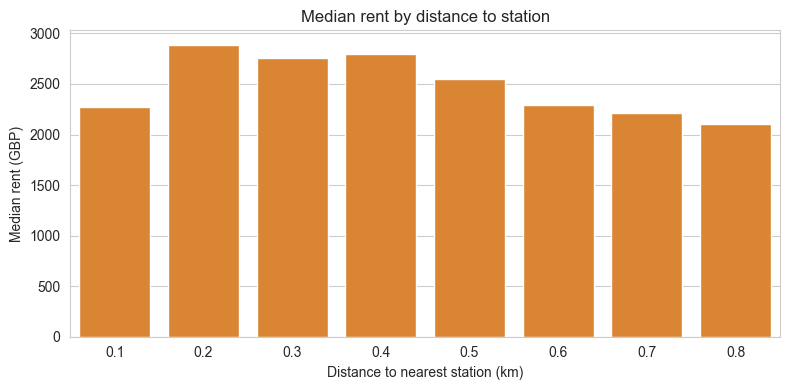

In [ ]:
dist_df = analysis_df[["avg_distance_to_nearest_station", "rent"]].dropna().copy()
dist_df = dist_df[dist_df["avg_distance_to_nearest_station"] > 0]

dist_q1, dist_q3 = dist_df["avg_distance_to_nearest_station"].quantile([0.25, 0.75])
dist_iqr = dist_q3 - dist_q1
dist_lower = dist_q1 - 1.5 * dist_iqr
dist_upper = dist_q3 + 1.5 * dist_iqr
dist_outlier_share = (
    (dist_df["avg_distance_to_nearest_station"] < dist_lower) |
    (dist_df["avg_distance_to_nearest_station"] > dist_upper)
).mean()

dist_df = dist_df[
    (dist_df["avg_distance_to_nearest_station"] >= dist_lower) &
    (dist_df["avg_distance_to_nearest_station"] <= dist_upper)
]

dist_mean = dist_df.groupby("avg_distance_to_nearest_station", observed=False)["rent"].mean().reset_index()
dist_outlier_share, dist_mean

fig, ax = plt.subplots(figsize=(8, 4))
dist_order = sorted(dist_df["avg_distance_to_nearest_station"].unique())
sns.barplot(
    x="avg_distance_to_nearest_station", y="rent", data=dist_df,
    order=dist_order, estimator=np.mean, errorbar=None, ax=ax, color="#F58518"
)
ax.set_title("Median rent by distance to station")
ax.set_xlabel("Distance to nearest station (km)")
ax.set_ylabel("Median rent (GBP)")
plt.tight_layout()


After removing about 5% of distance outliers (using an IQR rule), mean rent stays around 2,755-2,885 GBP for 0.2-0.4 km, then steps down steadily to ~2,100 GBP by 0.8 km. The distance values are discrete in this dataset, so each bar represents an actual distance level rather than a bin.


## 3. Key takeaways
- High-end rent outliers (>~5,800 GBP) and non-residential/shared property types are excluded to keep means representative.
- Apartments command higher rents than houses at the same bedroom count (e.g., 2-bed apartments ~3,032 GBP vs houses ~2,518 GBP).
- Size is a meaningful driver even after trimming extreme sizes (Pearson r around 0.46), but size is missing in ~71% of listings.
- Furnishing affects rent modestly; the effect is more visible for houses than for apartments.
- Rent declines as distance to the nearest station increases beyond ~0.4 km.
- However, properties within 100m from a station are significantly lower due to nuisance that this causes.


## 4. Tableau-ready dataset


In [6]:
tableau_df = analysis_df.copy()
tableau_df = tableau_df[tableau_df["size_sqft"].isna() | (tableau_df["size_sqft"] <= 1250)]
# Add a stable primary key for Tableau counting
tableau_df.insert(0, "property_id", range(1, len(tableau_df) + 1))

tableau_path = "../data/processed/rent_ads_prefiltered.csv"
tableau_df.to_csv(tableau_path, index=False)
tableau_path, tableau_df.shape


('../data/processed/rent_ads_prefiltered.csv', (2770, 16))